In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import itertools
import nltk

# import wordcloud
%matplotlib inline
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

In [3]:
data = pd.read_excel("Data/Online Retail.xlsx", dtype = {'StockCode':str})
data.head(3)

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom


In [4]:
data.shape

(541909, 8)

# Data Preprocessing

In [5]:
null_val = pd.DataFrame(data = data.isnull().sum(),columns = ['Null values'] )
null_val['% Null values'] = null_val/data.shape[0]*100
null_val.T

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
Null values,0.0,0.0,1454.000000,0.0,0.0,0.0,135080.000000,0.0
% Null values,0.0,0.0,0.268311,0.0,0.0,0.0,24.926694,0.0


> Since we don't have CustomerID for 25% customers we will remove the  customerid column as we cannot give them any arbitary values.

In [6]:
# Removing nall rows having customerID null
data.dropna(axis = 0, subset = ['CustomerID'], inplace = True)

In [7]:
# checking for duplicacy in data
data.duplicated().sum()

5225

In [8]:
# Droping the duplicated entries
data.drop_duplicates(inplace = True)
data.duplicated().sum()

0

# Exploratory Data Analysis (EDA)

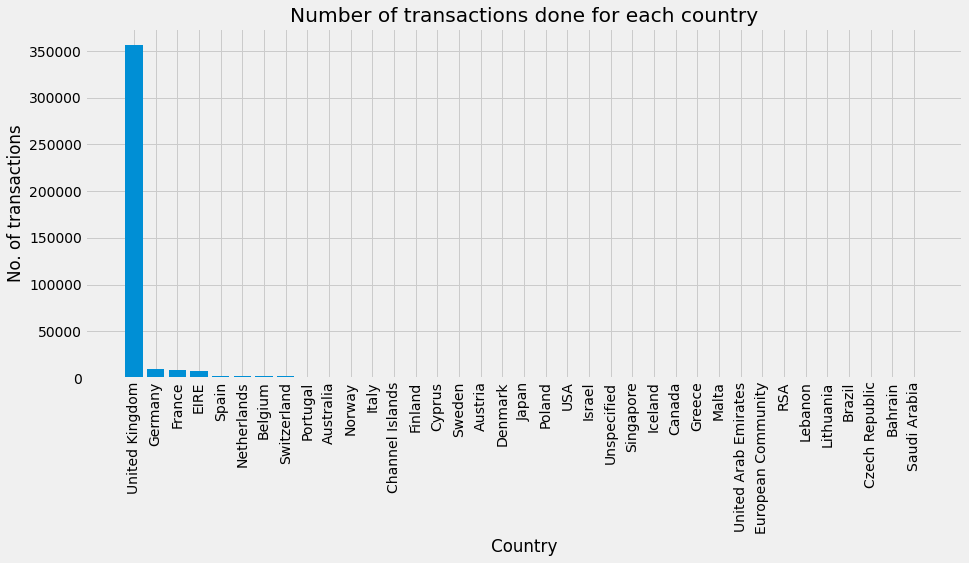

In [9]:
plt.figure(figsize=(14, 6))
country_counts = data['Country'].value_counts()
plt.bar(country_counts.index, country_counts.values)
plt.xticks(rotation=90, fontsize=14)
plt.title("Number of transactions done for each country")
plt.ylabel("No. of transactions")
plt.xlabel("Country")
plt.show()


In [10]:
total_trans  = pd.DataFrame(data = data.groupby(['Country'])['InvoiceNo'].nunique(), index = data.groupby(['Country']).groups.keys()).T
total_trans

,Australia,Austria,Bahrain,Belgium,Brazil,Canada,Channel Islands,Cyprus,Czech Republic,Denmark,...,RSA,Saudi Arabia,Singapore,Spain,Sweden,Switzerland,USA,United Arab Emirates,United Kingdom,Unspecified
InvoiceNo,69,19,2,119,1,6,33,20,5,21,...,1,2,10,105,46,71,7,3,19857,8


Conclusions 
1. UK has done most of the transanctions. (19857)
2. Least amount of transanctions were made by countries like Brazil, RSA etc. (only 1)

In [11]:
# Total no of different products that were sold in the year data was collected.
print("Totala no of products: ", len(data['StockCode'].value_counts()))

Totala no of products:  3684


In [12]:
# Total no of different transactions were done
print("Total no of Transactions:", len(data['InvoiceNo'].value_counts()))

Total no of Transactions: 22190


In [13]:
# Total no of different customers.
print("Total no of Customers:", len(data['CustomerID'].value_counts()))

Total no of Customers: 4372


Conclusion

There are 22k transanctions but only 4.4k customers with 3.7k products. It seems that some orders were placed then cancelled or the customers bought items multiple times or multiple items were bought in a single transanction.

In [14]:
df = data.groupby(['CustomerID', 'InvoiceNo'], as_index = False)['InvoiceDate'].count().rename(columns= {'InvoiceDate':'No of products'})
df[:10].sort_values(['CustomerID'])

,CustomerID,InvoiceNo,No of products
0,12346.0,541431,1
1,12346.0,C541433,1
2,12347.0,537626,31
3,12347.0,542237,29
4,12347.0,549222,24
5,12347.0,556201,18
6,12347.0,562032,22
7,12347.0,573511,47
8,12347.0,581180,11
9,12348.0,539318,17


Conclusion
1)  There are customers who purchase only 1 item per transanction and others who purchase many items per transanction.
2) There are some orders which were cancelled they are marked with 'C' in the beginning.

In [15]:
# Counting the number of cancelled transactions
df['orders cancelled'] = df['InvoiceNo'].apply(lambda x: int("C" in str(x)))

# Printing number of orders cancelled ->
print("Number of orders cancelled {}/{} ({:.2f}%)".format(df['orders cancelled'].sum(), df.shape[0], df['orders cancelled'].sum()/ df.shape[0] * 100))

Number of orders cancelled 3654/22190 (16.47%)


In [16]:
# Looking at cancelled transanctions in original data.
data.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom
61624,C541433,23166,MEDIUM CERAMIC TOP STORAGE JAR,-74215,2011-01-18 10:17:00,1.04,12346.0,United Kingdom
286623,562032,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-08-02 08:48:00,4.25,12347.0,Iceland
72260,542237,84991,60 TEATIME FAIRY CAKE CASES,24,2011-01-26 14:30:00,0.55,12347.0,Iceland
14943,537626,22772,PINK DRAWER KNOB ACRYLIC EDWARDIAN,12,2010-12-07 14:57:00,1.25,12347.0,Iceland


Conclusion

To cancel a order a new transaction has to be started with different InvoiceNo, With negative quantity and every other description is same . We can use this to remove the cancelled orders

In [17]:
# Checking for discounted products

df = data[data['Description'] == 'Discount']
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
141,C536379,D,Discount,-1,2010-12-01 09:41:00,27.50,14527.0,United Kingdom
9038,C537164,D,Discount,-1,2010-12-05 13:21:00,29.29,14527.0,United Kingdom
14498,C537597,D,Discount,-1,2010-12-07 12:34:00,281.00,15498.0,United Kingdom
19392,C537857,D,Discount,-1,2010-12-08 16:00:00,267.12,17340.0,United Kingdom
31134,C538897,D,Discount,-1,2010-12-15 09:14:00,5.76,16422.0,United Kingdom


So there are some discounted transanctions too but they appear to be cancelled.

##### Checking and dropping cancelled orders

In [18]:
# Removing cancelled orders

df_cleaned = data.copy(deep=True)

# Add a new column to track cancelled quantities
df_cleaned['QuantityCancelled'] = 0

# Lists to store indices of entries to remove and doubtful entries
entry_to_remove = []
doubtfull_entry = []

for index, col in data.iterrows():
    # Skip entries with positive quantity or those representing discounts
    if(col['Quantity'] > 0)or(col['Description']=='Discount'):
        continue

    # Extract data for potential cancelled orders
    df_test = data[(data['CustomerID']==col['CustomerID'])&(data['StockCode']==col['StockCode'])&
                   (data['InvoiceDate']<col['InvoiceDate'])&(data['Quantity']>0)].copy()
    
    # Order cancelled without counterpart, these are doubtful as they maybe errors or maybe orders were placed before data given
    if(df_test.shape[0] == 0):
        doubtfull_entry.append(index)
    
    # Cancellation with single counterpart
    elif(df_test.shape[0] == 1):
        index_order = df_test.index[0]
        df_cleaned.loc[index_order, 'QuantityCancelled'] = -col['Quantity']
        entry_to_remove.append(index)
        
    # Various counterpart exists for orders
    elif(df_test.shape[0] > 1):
        df_test.sort_index(axis = 0, ascending=False, inplace=True)
        for ind, val in df_test.iterrows():
            # Check if the counterpart quantity is sufficient to cancel the original order
            if val['Quantity'] < -col['Quantity']:
                continue
            df_cleaned.loc[ind, 'QuantityCancelled'] = -col['Quantity']
            entry_to_remove.append(index)
            break

In [19]:
print("Entry to remove {}".format(len(entry_to_remove)))
print("Doubtfull Entry {}".format(len(doubtfull_entry)))

Entry to remove 7521
Doubtfull Entry 1226


In [20]:
# Deleting these entries:
indices_to_drop = list(set(entry_to_remove + doubtfull_entry))

# Ensure that the indices to drop exist in the DataFrame
valid_indices = set(indices_to_drop).intersection(df_cleaned.index)

# Drop the valid indices from the DataFrame
df_cleaned.drop(valid_indices, axis=0, inplace=True)


StockCode feature especially the discounted items:

In [21]:
list_special_codes = df_cleaned[df_cleaned['StockCode'].str.contains('^[a-zA-Z]+', regex = True)]['StockCode'].unique()
list_special_codes

array(['POST', 'D', 'C2', 'M', 'BANK CHARGES', 'PADS', 'DOT'],
      dtype=object)

In [22]:
# getting the info what the stockode feture means
for code in list_special_codes:
    print("{:<17} -> {:<35}".format(code, df_cleaned[df_cleaned['StockCode'] == code]['Description'].values[0]))

POST              -> POSTAGE                            
D                 -> Discount                           
C2                -> CARRIAGE                           
M                 -> Manual                             
BANK CHARGES      -> Bank Charges                       
PADS              -> PADS TO MATCH ALL CUSHIONS         
DOT               -> DOTCOM POSTAGE                     


In [23]:
df_cleaned['QuantityCancelled'] = np.nan_to_num(df_cleaned['QuantityCancelled'])
df_cleaned.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCancelled
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom,0
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom,0
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom,0


Conclusion

We see that the same transanction is duplicated for every different item in the dataset. Like above invoice number 536365 the user probably purchased many different items and each have been given a row as shown. We will need to merge these so we will add the totalprice feature for each row.

In [24]:
# FInding the total pric for each transaction

df_cleaned['TotalPrice'] = df_cleaned['UnitPrice'] * (df_cleaned['Quantity'] - df_cleaned['QuantityCancelled'])
df_cleaned.sort_values('CustomerID')[:5]

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,QuantityCancelled,TotalPrice
61619,541431,23166,MEDIUM CERAMIC TOP STORAGE JAR,74215,2011-01-18 10:01:00,1.04,12346.0,United Kingdom,74215,0.0
148288,549222,22375,AIRLINE BAG VINTAGE JET SET BROWN,4,2011-04-07 10:43:00,4.25,12347.0,Iceland,0,17.0
428971,573511,22698,PINK REGENCY TEACUP AND SAUCER,12,2011-10-31 12:25:00,2.95,12347.0,Iceland,0,35.4
428970,573511,47559B,TEA TIME OVEN GLOVE,10,2011-10-31 12:25:00,1.25,12347.0,Iceland,0,12.5
428969,573511,47567B,TEA TIME KITCHEN APRON,6,2011-10-31 12:25:00,5.95,12347.0,Iceland,0,35.7


##### Now we sum the individual orders and group them on the basis of invoice number to remove the problem of duplicate rows for same order :

In [25]:
temp = df_cleaned.groupby(by = ['CustomerID', 'InvoiceNo'], as_index = False)['TotalPrice'].sum()
basket_price = temp.rename(columns = {'TotalPrice': 'Basket Price'})

df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index=False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace=True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID')[:5]

,CustomerID,InvoiceNo,Basket Price,InvoiceDate
1,12347.0,537626,711.79,2010-12-07 14:57:00.000000000
2,12347.0,542237,475.39,2011-01-26 14:29:59.999999744
3,12347.0,549222,636.25,2011-04-07 10:43:00.000000000
4,12347.0,556201,382.52,2011-06-09 13:01:00.000000000
5,12347.0,562032,584.91,2011-08-02 08:48:00.000000000


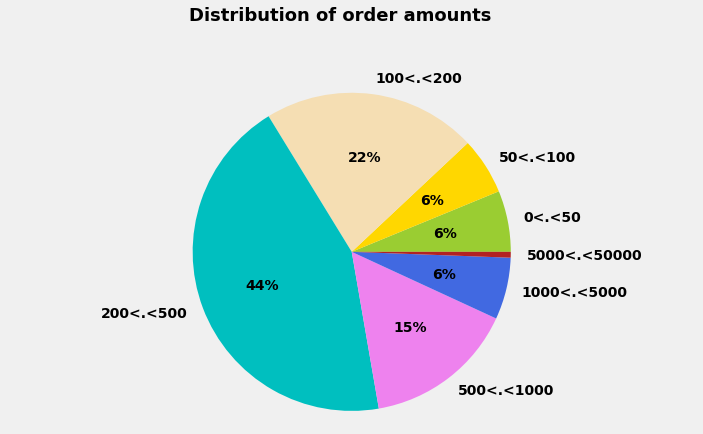

In [26]:
price_range = [0, 50, 100, 200, 500, 1000, 5000, 50000]

# Initialize an empty list to store the count of orders within each price range
count_price = []

# Iterate through the price ranges 
for i,price in enumerate(price_range):
    # Skip 1st iteration beacuse price_range[i-1] we are comparing previous
    if i==0:
        continue

    # Count the number of orders within the current price range
    val = basket_price[(basket_price['Basket Price'] < price)&
                       (basket_price['Basket Price'] > price_range[i-1])]['Basket Price'].count()
    count_price.append(val)
    
# Create a pie chart
plt.rc('font', weight='bold')
f, ax = plt.subplots(figsize=(11, 6))
colors = ['yellowgreen', 'gold', 'wheat', 'c', 'violet', 'royalblue', 'firebrick']
labels = ["{}<.<{}".format(price_range[i-1], s) for i,s in enumerate(price_range) if i != 0]
sizes = count_price
explode = [0.0 if sizes[i] < 100 else 0.0 for i in range(len(sizes))]

# Plot the pie chart
ax.pie(sizes, explode = explode, labels = labels, colors = colors,
       autopct = lambda x:'{:1.0f}%'.format(x) if x > 1 else '',
       shadow = False, startangle = 0)
ax.axis('equal')
f.text(0.5, 1.01, "Distribution of order amounts", ha = 'center', fontsize = 18)
plt.show()

#####  Analysing the product Description

In [27]:
is_noun = lambda pos: pos[:2] == 'NN'

def keywords_inventory(dataframe, colonne='Description'):
    import nltk
    import pandas as pd
    
    # Create a stemmer for English words
    stemmer = nltk.stem.SnowballStemmer("english")
    
    # Dictionaries to store information about keywords
    keywords_roots = dict()  # Root form of each keyword
    keywords_select = dict()  # Selected form of each keyword
    category_keys = []  # List of selected keywords
    count_keywords = dict()  # Count of each keyword occurrence
    
    # Iterate through each entry in the specified column of the DataFrame
    for s in dataframe[colonne]:
        if pd.isnull(s): continue  # Skip NaN values
        
        # Convert the text to lowercase
        lines = s.lower()
        
        # Tokenize the text into words
        tokenized = nltk.word_tokenize(lines)
        
        # Extract nouns using NLTK's part-of-speech tagging
        nouns = [word for (word, pos) in nltk.pos_tag(tokenized) if is_noun(pos)]
        
        # Process each noun
        for t in nouns:
            t = t.lower()  # Convert to lowercase
            racine = stemmer.stem(t)  # Stem the word using SnowballStemmer
            
            # Update dictionaries with information about the keyword
            if racine in keywords_roots:
                keywords_roots[racine].add(t)
                count_keywords[racine] += 1
            else:
                keywords_roots[racine] = {t}
                count_keywords[racine] = 1
    
    # Iterate through the roots of keywords
    for s in keywords_roots.keys():
        if len(keywords_roots[s]) > 1:
            # If multiple forms of the keyword exist, select the one with the minimum length
            min_length = 1000
            for k in keywords_roots[s]:
                if len(k) < min_length:
                    clef = k
                    min_length = len(k)
            
            # Append the selected form to the list of category keys
            category_keys.append(clef)
            
            # Update the selected keyword dictionary
            keywords_select[s] = clef
        
        else:
            # If only one form of the keyword exists, use it
            category_keys.append(list(keywords_roots[s])[0])
            keywords_select[s] = list(keywords_roots[s])[0]
    
    # Print the number of keywords and return relevant information
    print("Number of keywords in the variable '{}': {}".format(colonne, len(category_keys)))
    return category_keys, keywords_roots, keywords_select, count_keywords


In [28]:
df_produits = pd.DataFrame(data['Description'].unique()).rename(columns = {0:"Description"})

In [29]:
keywords, keywords_roots, keywords_select, count_keywords = keywords_inventory(df_produits)

Number of keywords in the variable 'Description': 1483


In [30]:
# Plotting keywords vs frequency graph :
list_products = []
for k, v in count_keywords.items():
    word = keywords_select[k]
    list_products.append([word, v])

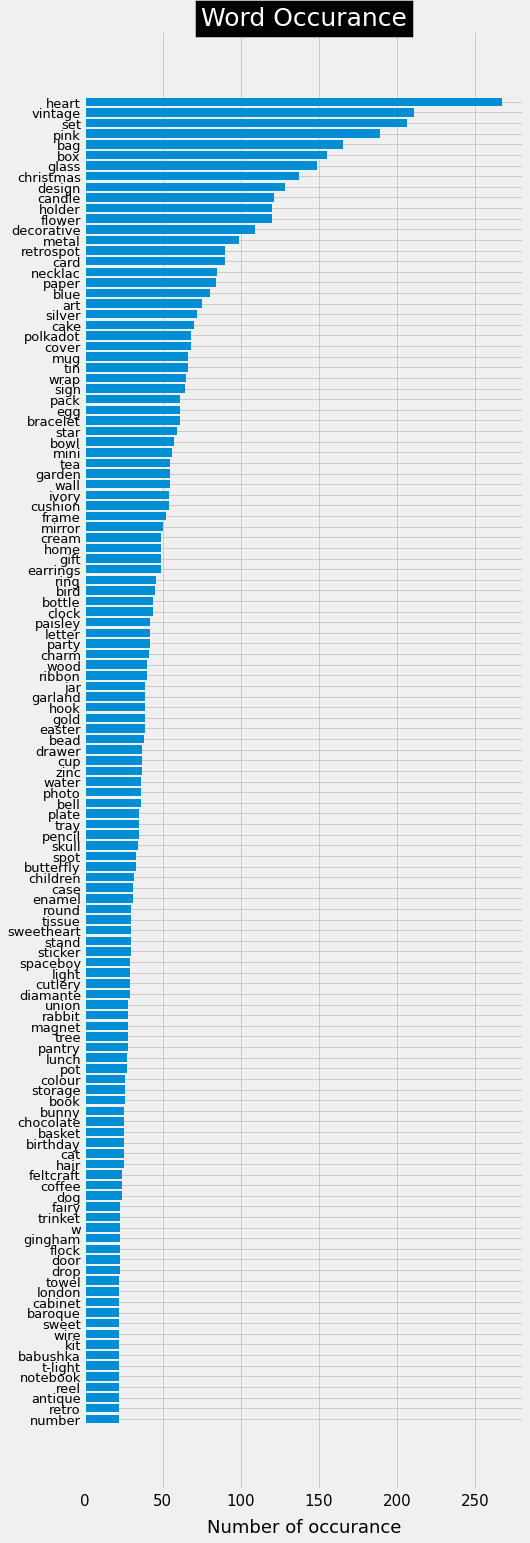

In [31]:
liste = sorted(list_products, key = lambda x:x[1], reverse=True)

plt.rc('font', weight='normal')
fig, ax = plt.subplots(figsize=(7, 25))
y_axis = [i[1] for i in liste[:125]]
x_axis = [k for k,i in enumerate(liste[:125])]
x_label = [i[0] for i in liste[:125]]
plt.xticks(fontsize=15)
plt.yticks(fontsize=13)
plt.yticks(x_axis, x_label)
plt.xlabel("Number of occurance", fontsize = 18, labelpad = 10)
ax.barh(x_axis, y_axis, align='center')
ax = plt.gca()
ax.invert_yaxis()

plt.title("Word Occurance", bbox={'facecolor':'k', 'pad':5}, color='w', fontsize = 25)
plt.show()

In [32]:
# Create an empty list to store important words along with their counts
list_products = []

# Iterate through the items in the count_keywords dictionary
for k, v in count_keywords.items():
    # Retrieve the selected form of the keyword
    word = keywords_select[k]
    
    # Skip certain words based on predefined criteria
    if word in ['pink', 'blue', 'tag', 'green', 'orange']:
        continue
    if len(word) < 3 or v < 13:
        continue
    
    # Append the word and its count to the list
    list_products.append([word, v])

# Sort the list of preserved words based on count in descending order
list_products.sort(key=lambda x: x[1], reverse=True)

# Print the number of preserved words
print("Number of preserved words:", len(list_products))


Number of preserved words: 193


##### Describing every product in terms of words present in the description :
1. We will only use the preserved words, this is just like Binary Bag of Words<br>
2. We need to convert this into a product matrix with products as rows and different words as columns. A cell contains a 1 if a particular product has that word in its description else it contains 0.
3. We will use this matrix to categorize the products.
4. We will add a mean price feature so that the groups are balanced.

In [33]:
# Define a threshold list for categorizing product prices
threshold = [0, 1, 2, 3, 5, 10]

# Get unique product descriptions from the cleaned DataFrame
liste_produits = df_cleaned['Description'].unique()

# Create an empty DataFrame to store product and word matrix
X = pd.DataFrame()

# Iterate through important words and create a matrix indicating the presence of each word in each product description
for key, occurence in list_products:
    X.loc[:, key] = list(map(lambda x: int(key.upper() in x), liste_produits))

# Create label columns based on the price threshold
label_col = []

# Iterate through the threshold values to create label columns
for i in range(len(threshold)):
    if i == len(threshold) - 1:
        col = 'Unit price>{}'.format(threshold[i])
    else:
        col = '{}<Unit price<{}'.format(threshold[i], threshold[i+1])
        
    label_col.append(col)
    X.loc[:, col] = 0

# Assign labels to products based on their average unit price and the defined threshold
for i, prod in enumerate(liste_produits):
    # Calculate the average unit price for each product
    prix = df_cleaned[df_cleaned['Description'] == prod]['UnitPrice'].mean()
    j = 0
    
    # Categorize the product based on the price threshold
    while prix > threshold[j]:
        j += 1
        if j == len(threshold):
            break
    X.loc[i, label_col[j-1]] = 1


In [ ]:
print("{:<8} \t\t{:<20} \n".format('Range', 'No of products') + 40*'-')
for i in range(len(threshold)):
    if i == len(threshold)-1:
        col = 'Unit price>{}'.format(threshold[i])
    else:
        col = '{}<Unit price<{}'.format(threshold[i],threshold[i+1])
    print("{:<10}\t\t{:<20}".format(col, X.loc[:, col].sum()))

Range    		No of products       
----------------------------------------
0<Unit price<1		964                 
1<Unit price<2		1009                
2<Unit price<3		673                 
3<Unit price<5		606                 
5<Unit price<10		470                 
Unit price>10		156                 


In [ ]:
X

,heart,vintage,set,bag,box,glass,christmas,design,candle,holder,...,lace,jewel,wallet,point,0<Unit price<1,1<Unit price<2,2<Unit price<3,3<Unit price<5,5<Unit price<10,Unit price>10
0,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
4,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3873,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3874,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3875,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3876,1,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0


# Clustring

1. KMEANS

In [ ]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

Silhouette analysis can be used to study the separation distance between the resulting clusters. The silhouette plot displays a measure of how close each point in one cluster is to points in the neighboring clusters and thus provides a way to assess parameters like number of clusters visually. This measure has a range of [-1, 1].

Silhouette coefficients (as these values are referred to as) near +1 indicate that the sample is far away from the neighboring clusters. A value of 0 indicates that the sample is on or very close to the decision boundary between two neighboring clusters and negative values indicate that those samples might have been assigned to the wrong cluster.

In [ ]:
matrix = X.to_numpy()

In [ ]:
# Iterate through a range of potential cluster numbers (3 to 9 in this case)
for n_clusters in range(3, 10):
    # Initialize KMeans with k-means++ initialization, specified cluster number, and 30 random initializations
    kmeans = KMeans(init='k-means++', n_clusters=n_clusters, n_init=30)

    # Fit the KMeans model to the data matrix
    kmeans.fit(matrix)
    
    # Predict the cluster labels for each data point in the matrix
    clusters = kmeans.predict(matrix)
    
    # Calculate the average silhouette score for the clustering
    sil_avg = silhouette_score(matrix, clusters)
    
    # Print the silhouette score for the current number of clusters
    print("For n_clusters:", n_clusters, "The average silhouette_score is:", sil_avg)


For n_clusters: 3 The average silhouette_score is: 0.10071681758064248
For n_clusters: 4 The average silhouette_score is: 0.12609893747265383
For n_clusters: 5 The average silhouette_score is: 0.12943216498035684
For n_clusters: 6 The average silhouette_score is: 0.1499333778465504
For n_clusters: 7 The average silhouette_score is: 0.15961172545889715
For n_clusters: 8 The average silhouette_score is: 0.15094863437302605
For n_clusters: 9 The average silhouette_score is: 0.13601720414044216


In [ ]:
# Using optimal number of clusters using hyperparameter tuning:
for n_clusters in range(3, 10):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    sil_avg = silhouette_score(matrix, clusters)
    print("For n_clusters : ", n_clusters, "The average silhouette_score is : ", sil_avg)

For n_clusters :  3 The average silhouette_score is :  0.10071681758064248
For n_clusters :  4 The average silhouette_score is :  0.12609893747265383
For n_clusters :  5 The average silhouette_score is :  0.1210247232124736
For n_clusters :  6 The average silhouette_score is :  0.14524437780972266
For n_clusters :  7 The average silhouette_score is :  0.14336243882901756
For n_clusters :  8 The average silhouette_score is :  0.16197123677599157
For n_clusters :  9 The average silhouette_score is :  0.14482102887888965


In [ ]:
# Choosing number of clusters as 5:
# Trying Improving the silhouette_score :
n_clusters = 6
sil_avg = -1
while sil_avg < 0.145:
    kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(matrix)
    clusters = kmeans.predict(matrix)
    sil_avg = silhouette_score(matrix, clusters)
    print("For n_clusters : ", n_clusters, "The average silhouette_score is : ", sil_avg)

For n_clusters :  6 The average silhouette_score is :  0.14389114353988738
For n_clusters :  6 The average silhouette_score is :  0.14389841472426354
For n_clusters :  6 The average silhouette_score is :  0.14389841472426354
For n_clusters :  6 The average silhouette_score is :  0.14389841472426354
For n_clusters :  6 The average silhouette_score is :  0.14524437780972266


In [ ]:
# Number of elements in each cluster :
pd.Series(clusters).value_counts()

1    917
4    892
0    704
3    628
5    438
2    299
Name: count, dtype: int64

In [ ]:
def graph_component_silhouette(n_clusters, lim_x, mat_size, sample_silhouette_values, clusters):
    import matplotlib as mpl
    import matplotlib.pyplot as plt
    import numpy as np
    
    # Set matplotlib configuration for patch edges
    mpl.rc('patch', edgecolor='dimgray', linewidth=1)

    # Create a subplot with specified dimensions
    fig, ax1 = plt.subplots(1, 1)
    fig.set_size_inches(8, 8)

    # Set x-axis and y-axis limits
    ax1.set_xlim([lim_x[0], lim_x[1]])
    ax1.set_ylim([0, mat_size + (n_clusters + 1) * 10])
    
    # Initialize y_lower for the silhouette plot
    y_lower = 10

    # Iterate through clusters to create silhouette plots
    for i in range(n_clusters):
        # Extract silhouette values for the current cluster
        ith_cluster_silhouette_values = sample_silhouette_values[clusters == i]
        
        # Sort silhouette values
        ith_cluster_silhouette_values.sort()
        
        # Calculate the size of the current cluster
        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        
        # Set y_upper for the silhouette plot
        y_upper = y_lower + size_cluster_i
        
        # Fill the area between 0 and silhouette values for the current cluster
        ax1.fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_silhouette_values, alpha=0.8)
        
        # Add a label for the cluster number
        ax1.text(-0.03, y_lower + 0.5 * size_cluster_i, str(i), color='red', fontweight='bold',
                 bbox=dict(facecolor='white', edgecolor='black', boxstyle='round, pad=0.3'))
        
        # Update y_lower for the next cluster
        y_lower = y_upper + 10

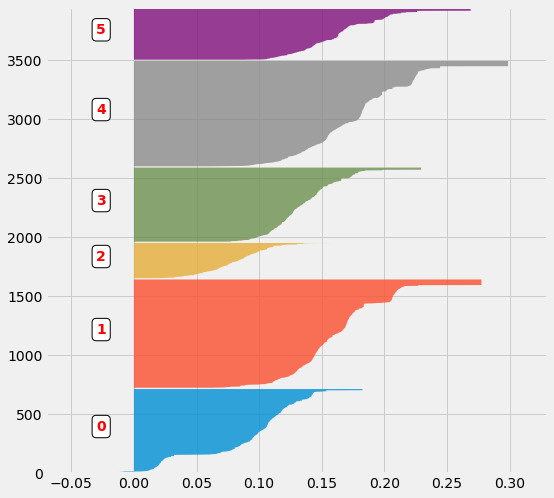

In [ ]:
# Plotting the intra cluster silhouette distances.
from sklearn.metrics import silhouette_samples
sample_silhouette_values = silhouette_samples(matrix, clusters)
graph_component_silhouette(n_clusters, [-0.07, 0.33], len(X), sample_silhouette_values, clusters)

## Dimensionality Reduction:
> PCA

In [50]:
from sklearn.decomposition import PCA

In [51]:
pca = PCA()
pca.fit(matrix)
pca_samples = pca.transform(matrix)

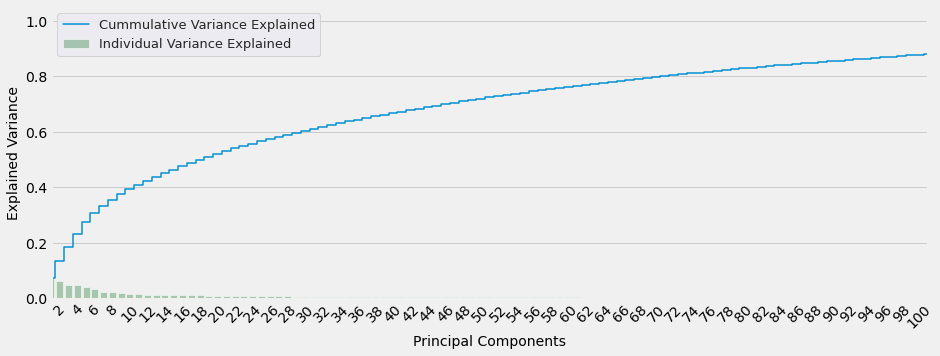

In [52]:
# Checking the amount of variance explained :
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where = 'mid', label = 'Cummulative Variance Explained')
sns.barplot(np.arange(1, matrix.shape[1] + 1), pca.explained_variance_ratio_, alpha = 0.5, color = 'g',
            label = 'Individual Variance Explained')
plt.xlim(0, 100)
plt.xticks(rotation = 45, fontsize = 14)
ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel("Explained Variance", fontsize = 14)
plt.xlabel("Principal Components", fontsize = 14)
plt.legend(loc = 'upper left', fontsize = 13)
plt.show()

We need more than 100 Principal Components to explain more than 90 % of the variance.
<br>

## Generating Customer Segments/Categories :
1. We will use the already generated product categories and create a new feature which tells to which category the product belongs to.

In [53]:
corresp = dict()
for key, val in zip(liste_produits, clusters):
    corresp[key] = val
    
df_cleaned['categ_product'] = df_cleaned.loc[:, 'Description'].map(corresp)
df_cleaned[['InvoiceNo', 'Description', 'categ_product']][:10]

,InvoiceNo,Description,categ_product
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,1
1,536365,WHITE METAL LANTERN,0
2,536365,CREAM CUPID HEARTS COAT HANGER,0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,0
5,536365,SET 7 BABUSHKA NESTING BOXES,4
6,536365,GLASS STAR FROSTED T-LIGHT HOLDER,0
7,536366,HAND WARMER UNION JACK,1
8,536366,HAND WARMER RED POLKA DOT,2
9,536367,ASSORTED COLOUR BIRD ORNAMENT,2


In [54]:
# Creating 5 new features that will contain the amount in a single transanction on different categories of product. filling empty values with 0.
for i in range(5):
    col = 'categ_{}'.format(i)
    df_temp = df_cleaned[df_cleaned['categ_product'] == i]
    # Getting the total price for the specifc transaction.
    price_temp = df_temp['UnitPrice'] * (df_temp['Quantity'] - df_temp['QuantityCancelled'])
    price_temp = price_temp.apply(lambda x:x if x > 0 else 0)
    df_cleaned.loc[:, col] = price_temp
    df_cleaned[col].fillna(0, inplace = True)
    
df_cleaned[['InvoiceNo', 'Description', 'categ_product', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']][:10]

,InvoiceNo,Description,categ_product,categ_0,categ_1,categ_2,categ_3,categ_4
0,536365,WHITE HANGING HEART T-LIGHT HOLDER,1,0.00,15.3,0.00,0.0,0.0
1,536365,WHITE METAL LANTERN,0,20.34,0.0,0.00,0.0,0.0
2,536365,CREAM CUPID HEARTS COAT HANGER,0,22.00,0.0,0.00,0.0,0.0
3,536365,KNITTED UNION FLAG HOT WATER BOTTLE,0,20.34,0.0,0.00,0.0,0.0
4,536365,RED WOOLLY HOTTIE WHITE HEART.,0,20.34,0.0,0.00,0.0,0.0
5,536365,SET 7 BABUSHKA NESTING BOXES,4,0.00,0.0,0.00,0.0,15.3
6,536365,GLASS STAR FROSTED T-LIGHT HOLDER,0,25.50,0.0,0.00,0.0,0.0
7,536366,HAND WARMER UNION JACK,1,0.00,11.1,0.00,0.0,0.0
8,536366,HAND WARMER RED POLKA DOT,2,0.00,0.0,11.10,0.0,0.0
9,536367,ASSORTED COLOUR BIRD ORNAMENT,2,0.00,0.0,54.08,0.0,0.0


##### A single order is split into multiple entries we will basket them :

In [67]:
# sum of purchases by user and order.
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index = False)['TotalPrice'].sum()
basket_price = temp.rename(columns={'TotalPrice': 'Basket Price'})

# percentage spent on each product category 
for i in range(5):
    col = "categ_{}".format(i)
    temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index = False)[col].sum()
    basket_price.loc[:, col] = temp[col]

# Dates of the order.
df_cleaned['InvoiceDate_int'] = df_cleaned['InvoiceDate'].astype('int64')
temp = df_cleaned.groupby(by=['CustomerID', 'InvoiceNo'], as_index = False)['InvoiceDate_int'].mean()
df_cleaned.drop('InvoiceDate_int', axis = 1, inplace=True)
basket_price.loc[:, 'InvoiceDate'] = pd.to_datetime(temp['InvoiceDate_int'])

# Selecting entries with basket price > 0.
basket_price = basket_price[basket_price['Basket Price'] > 0]
basket_price.sort_values('CustomerID', ascending=True)[:5]

,CustomerID,InvoiceNo,Basket Price,categ_0,categ_1,categ_2,categ_3,categ_4,InvoiceDate
1,12347.0,537626,711.79,293.35,83.40,187.2,23.40,124.44,2010-12-07 14:57:00.000000000
2,12347.0,542237,475.39,169.20,53.10,130.5,84.34,38.25,2011-01-26 14:29:59.999999744
3,12347.0,549222,636.25,115.00,71.10,330.9,81.00,38.25,2011-04-07 10:43:00.000000000
4,12347.0,556201,382.52,168.76,78.06,74.4,41.40,19.90,2011-06-09 13:01:00.000000000
5,12347.0,562032,584.91,158.16,119.70,109.7,61.30,136.05,2011-08-02 08:48:00.000000000


In [68]:
basket_price['InvoiceDate'].min()

Timestamp('2010-12-01 08:26:00')

In [70]:
basket_price['InvoiceDate'].max()

Timestamp('2011-12-09 12:50:00')

We have invoice for 1 year range

##### Grouping Orders:

We will get info about every customer on how much do they purchase, total number of orders. etc

In [74]:
transanctions_per_user = basket_price.groupby(by=['CustomerID'])['Basket Price'].agg(['count', 'min', 'max', 'mean', 'sum'])

# percentage of amout by category
for i in range(5):
    col = 'categ_{}'.format(i)
    transanctions_per_user.loc[:, col] = basket_price.groupby(by=['CustomerID'])[col].sum() / transanctions_per_user['sum'] * 100
    
transanctions_per_user.reset_index(drop = False, inplace = True)
basket_price.groupby(by=['CustomerID'])['categ_0'].sum()
transanctions_per_user.sort_values('CustomerID', ascending = True).head()

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4
0,12347.0,7,224.82,1294.32,615.714286,4310.00,29.540371,20.805104,26.375870,11.237123,12.041531
1,12348.0,4,227.44,892.80,449.310000,1797.24,0.000000,0.000000,41.953217,38.016069,20.030714
2,12349.0,1,1757.55,1757.55,1757.550000,1757.55,10.713778,12.245455,26.506216,4.513101,46.021450
3,12350.0,1,334.40,334.40,334.400000,334.40,0.000000,27.900718,48.444976,11.692584,11.961722
4,12352.0,7,144.35,840.30,340.815714,2385.71,14.601523,4.071325,15.705178,1.299404,64.322571


In [75]:
# Generating two new variables - days since first puchase and days since last purchase.
last_date = basket_price['InvoiceDate'].max().date()

first_registration = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].min())
last_purchase = pd.DataFrame(basket_price.groupby(by=['CustomerID'])['InvoiceDate'].max())

test = first_registration.applymap(lambda x:(last_date - x.date()).days)
test2 = last_purchase.applymap(lambda x:(last_date - x.date()).days)

transanctions_per_user.loc[:, 'LastPurchase'] = test2.reset_index(drop = False)['InvoiceDate']
transanctions_per_user.loc[:, 'FirstPurchase'] = test.reset_index(drop = False)['InvoiceDate']
transanctions_per_user.head()

,CustomerID,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase
0,12347.0,7,224.82,1294.32,615.714286,4310.00,29.540371,20.805104,26.375870,11.237123,12.041531,2,367
1,12348.0,4,227.44,892.80,449.310000,1797.24,0.000000,0.000000,41.953217,38.016069,20.030714,75,358
2,12349.0,1,1757.55,1757.55,1757.550000,1757.55,10.713778,12.245455,26.506216,4.513101,46.021450,18,18
3,12350.0,1,334.40,334.40,334.400000,334.40,0.000000,27.900718,48.444976,11.692584,11.961722,310,310
4,12352.0,7,144.35,840.30,340.815714,2385.71,14.601523,4.071325,15.705178,1.299404,64.322571,36,296


#### We need to focus on customers who only placed one order, our objective is to target these customers in a way to retains them.

In [76]:
n1 = transanctions_per_user[transanctions_per_user['count'] == 1].shape[0]
n2 = transanctions_per_user.shape[0]
print("No. of Customers with single purchase : {:<2}/{:<5} ({:<2.2f}%)".format(n1, n2, n1/n2*100))

No. of Customers with single purchase : 1489/4327  (34.41%)


#### Building Customers Segements:

In [77]:
list_cols = ['count', 'min', 'max', 'mean', 'categ_0', 'categ_1', 'categ_2', 'categ_3', 'categ_4']
selected_customers = transanctions_per_user.copy(deep=True)
matrix = selected_customers[list_cols].to_numpy()

In [79]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(matrix)
scaled_matrix = scaler.transform(matrix)

In [80]:
pca = PCA()
pca.fit(scaled_matrix)
pca_samples = pca.transform(scaled_matrix)

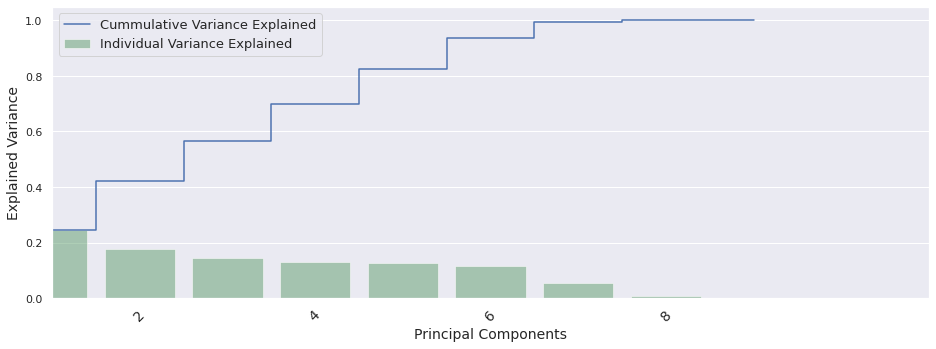

In [81]:
# Checking the amount of variance explained :
fig, ax = plt.subplots(figsize=(14, 5))
sns.set(font_scale=1)
plt.step(range(matrix.shape[1]), pca.explained_variance_ratio_.cumsum(), where = 'mid', label = 'Cummulative Variance Explained')
sns.barplot(np.arange(1, matrix.shape[1] + 1), pca.explained_variance_ratio_, alpha = 0.5, color = 'g',
            label = 'Individual Variance Explained')
plt.xlim(0, 10)
plt.xticks(rotation = 45, fontsize = 14)
ax.set_xticklabels([s if int(s.get_text())%2 == 0 else '' for s in ax.get_xticklabels()])

plt.ylabel("Explained Variance", fontsize = 14)
plt.xlabel("Principal Components", fontsize = 14)
plt.legend(loc = 'upper left', fontsize = 13)
plt.show()

In [82]:
# Using optimal number of clusters using hyperparameter tuning:
for n_clusters in range(3, 21):
    kmeans = KMeans(init='k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    sil_avg = silhouette_score(scaled_matrix, clusters)
    print("For n_clusters : ", n_clusters, "The average silhouette_score is : ", sil_avg)

For n_clusters :  3 The average silhouette_score is :  0.1584466640702452
For n_clusters :  4 The average silhouette_score is :  0.15268865780743088
For n_clusters :  5 The average silhouette_score is :  0.16698250587221639
For n_clusters :  6 The average silhouette_score is :  0.17124700848815227
For n_clusters :  7 The average silhouette_score is :  0.18927527520682924
For n_clusters :  8 The average silhouette_score is :  0.19244649458409227
For n_clusters :  9 The average silhouette_score is :  0.21354617368529877
For n_clusters :  10 The average silhouette_score is :  0.21337504797130993
For n_clusters :  11 The average silhouette_score is :  0.22249986277359463
For n_clusters :  12 The average silhouette_score is :  0.18328055667909068
For n_clusters :  13 The average silhouette_score is :  0.1869428945650003
For n_clusters :  14 The average silhouette_score is :  0.18743750029348066
For n_clusters :  15 The average silhouette_score is :  0.18061771761375073
For n_clusters :  16 

In [83]:
# Choosing number of clusters as 9:
# Trying Improving the silhouette_score :
n_clusters = 9
sil_avg = -1
while sil_avg < 0.208:
    kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init = 30)
    kmeans.fit(scaled_matrix)
    clusters = kmeans.predict(scaled_matrix)
    sil_avg = silhouette_score(scaled_matrix, clusters)
    print("For n_clusters : ", n_clusters, "The average silhouette_score is : ", sil_avg)

For n_clusters :  9 The average silhouette_score is :  0.2126338581917064


In [84]:
n_clusters = 9
kmeans = KMeans(init = 'k-means++', n_clusters = n_clusters, n_init = 100)
kmeans.fit(scaled_matrix)
clusters_clients = kmeans.predict(scaled_matrix)
silhouette_avg = silhouette_score(scaled_matrix, clusters_clients)
print("Silhouette Score : {:<.3f}".format(silhouette_avg))

Silhouette Score : 0.213


In [100]:
# Looking at clusters :
pd.DataFrame(clusters_clients, columns=['cluster']).value_counts().T

cluster
0          1879
1           589
5           579
8           362
6           355
4           313
7           208
3            30
2            12
Name: count, dtype: int64

There is a large difference in cluster segments, We will analyze these clusters further.

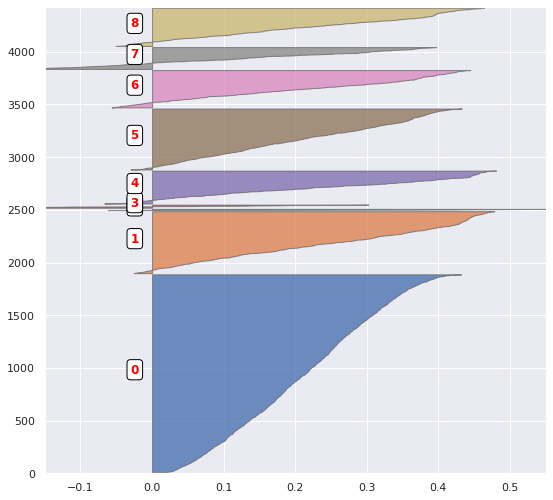

In [101]:
sample_silhouette_values = silhouette_samples(scaled_matrix, clusters_clients)

graph_component_silhouette(n_clusters, [-0.15, 0.55], len(scaled_matrix), sample_silhouette_values, clusters_clients)

From this above graph we can rest assured that all the clusters are disjoint

##### Now we need to learn the habits of the customers to do that we will add the variables that define a cluster to which each customer belong:

In [103]:
selected_customers.loc[:, 'cluster'] = clusters_clients

In [105]:
# Create an empty DataFrame to store merged results
merged_df = pd.DataFrame()

# Iterate through clusters
for i in range(n_clusters):
    # Create a DataFrame with the mean values of selected_customers for the current cluster
    test = pd.DataFrame(selected_customers[selected_customers['cluster'] == i].mean())
    
    # Transpose the DataFrame and set 'cluster' as the index
    test = test.T.set_index('cluster', drop=True)
    
    # Add a column 'size' with the number of customers in the current cluster
    test['size'] = selected_customers[selected_customers['cluster'] == i].shape[0]
    
    # Concatenate the current cluster's results to the merged DataFrame
    merged_df = pd.concat([merged_df, test])

# Drop the 'CustomerID' column from the merged DataFrame
merged_df.drop('CustomerID', axis=1, inplace=True)

# Print the total number of customers
print('Number of customers:', merged_df['size'].sum())

# Sort the merged DataFrame by the 'sum' column
merged_df = merged_df.sort_values('sum')


Number of customers: 4327


In [106]:
# Create an empty list to store cluster indices
liste_index = []

# Iterate through the first 5 categories
for i in range(5):
    # Generate the column name for the current category
    column = 'categ_{}'.format(i)
    
    # Find the index value of the first row where the value in the category column is greater than 45
    liste_index.append(merged_df[merged_df[column] > 45].index.values[0])

# Duplicate the list for reordering
liste_index_reordered = liste_index

# Extend the reordered list with indices that are not in the original list
liste_index_reordered += [s for s in merged_df.index if s not in liste_index]

# Reorder the merged DataFrame based on the reordered list of indices
merged_df = merged_df.reindex(index=liste_index_reordered)

# Reset the index and drop the old index column
merged_df = merged_df.reset_index(drop=False)

# Display the first few rows of the reordered DataFrame
merged_df.head()

,cluster,count,min,max,mean,sum,categ_0,categ_1,categ_2,categ_3,categ_4,LastPurchase,FirstPurchase,size
0,6.0,2.670423,200.800817,364.292535,269.508333,897.865268,51.067425,13.579462,13.563776,7.441845,14.375850,101.045070,190.853521,355
1,4.0,3.415335,194.255399,419.584952,297.118932,1165.155463,7.287064,63.306308,13.559224,6.773214,9.074191,104.801917,222.763578,313
2,5.0,2.730570,201.354456,338.417047,265.159327,758.323870,8.694561,14.116507,55.332447,12.813274,9.055956,108.815199,201.310881,579
3,8.0,2.566298,184.150801,324.742431,242.992252,699.678867,7.549265,12.573494,20.896481,50.747698,8.234142,105.044199,194.317680,362
4,1.0,3.193548,202.773329,371.284295,273.149367,929.210749,11.762312,11.247755,11.678947,5.219001,60.101736,131.448217,232.415959,589


##### Saving the selected customer dataframe and above dataframe to csv so that we do not need to do all this again :

In [109]:
selected_customers.to_csv("selected_customers.csv")
merged_df.to_csv("merged_df.csv")